In [ ]:
!conda install -c conda-forge folium

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import requests
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
df1 = pd.read_csv('http://bostonopendata-boston.opendata.arcgis.com/datasets/e5a0066d38ac4e2abbc7918197a4f6af_6.csv')

In [3]:
df1 = df1[['Y', 'X', 'NAME', 'NEIGHBORHOOD']]
#df[['color', 'food', 'score']]
df1.sort_values(by = 'NAME', inplace = True)
#df1.reset_index()
df1.rename(columns = {'NEIGHBORHOOD': 'District'}, inplace = True)
df1 = df1.drop(df1[df1.NAME == 'Boston Police Headquarters'].index)

In [4]:
df1['NAME'] = df1['NAME'].str.extract(r'\s(.*?)\s', expand=False)
df1['NAME'] = df1['NAME'].str.replace('-','')

In [5]:
df1['District'] = df1['District'].str.replace('Brighton','Allston/Brighton')

In [ ]:
df1 #uses for name police station markers

In [6]:
df1_fin = df1[['NAME','District']]
#df3.sort_values(by = "NAME", inplace = True)
#df3.reset_index()
df1_fin #uses far

,NAME,District
3,A1,Boston
5,A15,Charlestown
2,A7,East Boston
9,B2,Roxbury
11,B3,Mattapan
12,C11,Dorchester
6,C6,South Boston
4,D14,Allston/Brighton
7,D4,Boston
10,E13,Jamaica Plain


In [7]:
!wget --quiet http://bostonopendata-boston.opendata.arcgis.com/datasets/a6488cfd737b4955bf55b0342c74575b_0.geojson -O boston_geo.json

In [8]:
distr = []
with open ('boston_geo.json') as f:
    data = json.load(f)

for feature in data['features']:
    distr.append(feature['properties']['PD'])
df2 = pd.DataFrame(distr, columns = ['District'])

In [ ]:
df2

In [9]:
df_res = pd.merge(df2, df1_fin, on='District', how='left')

df_res

,District,NAME
0,East Boston,A7
1,Charlestown,A15
2,South Boston,C6
3,Central,NaN
4,Back Bay/Beacon Hill,NaN
5,South End,NaN
6,Fenway/Kenmore,NaN
7,Allston/Brighton,D14
8,Jamaica Plain,E13
9,Roxbury,B2


In [10]:
df_res.loc[(df_res.District == 'Central') | (df_res.District == 'Harbor Islands'),'NAME'] = 'A1'
df_res.loc[(df_res.District == 'South End') | (df_res.District == 'Fenway/Kenmore') | (df_res.District == 'Back Bay/Beacon Hill'), 'NAME'] = 'D4'    
df_res.loc[(df_res.District == 'South Dorchester') | (df_res.District == 'North Dorchester'),'NAME'] = 'C11'
df_res.loc[df_res['District'] == 'Roslindale', 'NAME'] = 'E5'

In [ ]:
df_res

In [11]:
df3 = pd.read_csv('https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpzo7dbtvq.csv',
                  index_col=False)

In [12]:
df3 = df3[df3['YEAR'] > 2017] #take 2018 and 2019 years crime only

In [ ]:
df3.head()

In [13]:
df3.rename(columns = {'DISTRICT': 'NAME'}, inplace = True)


In [14]:
df3.sort_values(by = 'NAME', inplace = True)

In [15]:
df3_res = df3[['NAME','INCIDENT_NUMBER']]
df3_res.head()

,NAME,INCIDENT_NUMBER
92562,A1,I182084895
133369,A1,I182042005
35200,A1,I192041034
35197,A1,I192041037
35193,A1,I192041042


In [16]:
df3_fin = df3_res.groupby('NAME').count()

In [17]:
df3_fin = df3_fin.reset_index()

In [18]:
df3_fin.drop(df3_fin[df3_fin['NAME'] == 'External'].index, inplace = True)

In [ ]:
df3_fin

In [19]:
df_fin = pd.merge(df_res, df3_fin, on='NAME')

df_fin #need for choropleth

,District,NAME,INCIDENT_NUMBER
0,East Boston,A7,7082
1,Charlestown,A15,3724
2,South Boston,C6,13724
3,Central,A1,20867
4,Harbor Islands,A1,20867
5,Back Bay/Beacon Hill,D4,23529
6,South End,D4,23529
7,Fenway/Kenmore,D4,23529
8,Allston/Brighton,D14,11535
9,Jamaica Plain,E13,10271


In [ ]:
df_fin.shape

# Map

In [121]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="bos_explorer")
location = geolocator.geocode(address)
latitude_b = location.latitude
longitude_b = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude_b, longitude_b))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [122]:
response = requests.get('http://bostonopendata-boston.opendata.arcgis.com/datasets/a6488cfd737b4955bf55b0342c74575b_0.geojson')
bos_geo = response.json()

In [123]:
map_boston = folium.Map(location=[latitude_b, longitude_b], zoom_start=13)
#Crime rate vizualization
folium.Choropleth(
    geo_data=bos_geo,
    name = 'choropleth',
    data=df_fin,
    columns=['District', 'INCIDENT_NUMBER'],
    key_on='feature.properties.PD',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Boston crime incidents 2018-2019'
).add_to(map_boston)

#Districts borders:

layer_geom = folium.FeatureGroup(name='Dist-s borders',control= True)
list_tooltip_vars = []
for i in range(len(bos_geo["features"])):
    temp_geojson = {"features":[bos_geo["features"][i]],"type":"FeatureCollection"}
    temp_geojson_layer = folium.GeoJson(temp_geojson,
                   highlight_function=lambda x: {'weight':3, 'color':'black'},
                    control=False,
                    style_function=lambda feature: {
                   'color': 'black',
                   'weight': 1},
                    tooltip=folium.features.GeoJsonTooltip(fields=list_tooltip_vars,
                                        aliases=[x.capitalize()+":" for x in list_tooltip_vars], 
                                          labels=True, 
                                          sticky=False))
    folium.Popup(temp_geojson["features"][0]["properties"]["PD"]).add_to(temp_geojson_layer)
    temp_geojson_layer.add_to(layer_geom)
layer_geom.add_to(map_boston)

folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_boston)
map_boston
#type(map_boston)

# Getting coordinates for clusters

In [114]:
df_lib = pd.read_csv('http://bostonopendata-boston.opendata.arcgis.com/datasets/cb00f9248aa6404ab741071ca3806c0e_6.csv')
df_lib = df_lib[['X', 'Y', 'DISTRICT', 'BRANCH']]
df_lib.head(2)

,X,Y,DISTRICT,BRANCH
0,-71.065006,42.361447,,West End
1,-71.070968,42.287519,,Codman Square


In [109]:
marks_only_map = folium.Map(location=[latitude_b, longitude_b], zoom_start=13)
folium.Choropleth(
    geo_data=bos_geo,
    name = 'choropleth',
    data=df_fin,
    columns=['District', 'INCIDENT_NUMBER'],
    key_on='feature.properties.PD',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Boston crime incidents 2018-2019'
).add_to(marks_only_map)

lt = list(df_lib.Y)
lg = list(df_lib.X)
lls = list(df_lib.DISTRICT)
lls1 = list(df_lib.BRANCH)

feature_group = folium.FeatureGroup(name='Public Libraries',control= True)
for lt, lg, l, l1 in zip(lt, lg, lls, lls1):
    folium.Marker([lt, lg],popup=[l, l1]).add_to(feature_group)

    
feature_group.add_to(marks_only_map)
folium.LayerControl(autoZIndex=False, collapsed=True).add_to(marks_only_map)
marks_only_map

In [115]:
to_drop = ['West End','Honan-Allston', 'Faneuil', 'Parker Hill', 'Jamaica Plain', 'Dudley', 'Grove Hall',
           'Fields Corner', 'Codman Square', 'Lower Mills']
for i in range(0,len(to_drop)):
    df_lib.drop(df_lib[df_lib.BRANCH == to_drop[i]].index, inplace = True)
    
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Brighton','Allston/Brighton')
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Egleston Square','Roxbury')
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Uphams Corner','North Dorchester')
df_lib['DISTRICT'] = df_lib['DISTRICT'].str.replace('COPLEY SQUARE','CENTRAL')


ind = []
for i in df_lib.loc[df_lib['DISTRICT'] == " "].index:
    ind.append(i)
df_lib['DISTRICT'].mask(df_lib['DISTRICT'] == " ", df_lib.BRANCH[ind], inplace=True)
df_lib['DISTRICT'] = df_lib['DISTRICT'].str.upper()


df_lib.rename(columns = {'X' : 'Longitude', 'Y': 'Latitude', 'DISTRICT' : 'NEIGH'}, inplace = True)
del df_lib['BRANCH']


In [118]:
df_lib.head(3)

,index,Longitude,Latitude,NEIGH
0,2,-71.122136,42.257104,HYDE PARK
1,3,-71.111099,42.320646,JAMAICA PLAIN
2,5,-71.078869,42.349435,CENTRAL


In [117]:
df_lib.reset_index(inplace = True)

In [124]:
lat = list(df_lib.Latitude)
long = list(df_lib.Longitude)
labels = list(df_lib.NEIGH)

for ltt, lng, lab in zip(lat, long, labels):
    folium.Marker([ltt, lng],
                  popup = lab).add_to(map_boston)

map_boston

# Clusters

In [125]:
CLIENT_ID = 'NZDQSGAU3EWXT0QIX0323PSYHEPD5TDVCLYX21O5BEBU22Q4' # your Foursquare ID
CLIENT_SECRET = 'WPKHRS1DRIIUKMHJG3OJ4NHGD2XXB5BE2G3KFBZVPL2A4HDC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 #

In [126]:
def getNearbyVenues(names, latitudes, longitudes, radius = 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGH', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [127]:
bos_venues = getNearbyVenues(names=df_lib['NEIGH'], latitudes=df_lib['Latitude'], longitudes=df_lib['Longitude'])

In [ ]:
bos_venues.head()

In [128]:
bos_venues.shape

(1027, 7)

In [129]:
bos_venues.groupby('NEIGH').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
NEIGH,,,,,,
SOUTH BOSTON,82,82,82,82,82,82
ALLSTON/BRIGHTON,76,76,76,76,76,76
CENTRAL,100,100,100,100,100,100
CHARLESTOWN,67,67,67,67,67,67
CHINATOWN,100,100,100,100,100,100
DORCHESTER,55,55,55,55,55,55
EAST BOSTON,57,57,57,57,57,57
HYDE PARK,31,31,31,31,31,31
JAMAICA PLAIN,71,71,71,71,71,71


In [130]:
print('There are {} uniques categories.'.format(len(bos_venues['Venue Category'].unique())))

There are 197 uniques categories.


In [131]:
df_viz = bos_venues.groupby('NEIGH').count()

In [132]:
df_viz.reset_index(inplace = True)

In [ ]:
df_viz.columns

In [135]:
df_viz = df_viz[['NEIGH', 'Venue']]
df_viz.sort_values(by = 'Venue', inplace = True)
df_viz.set_index('NEIGH', inplace = True)

KeyError: "['NEIGH'] not in index"

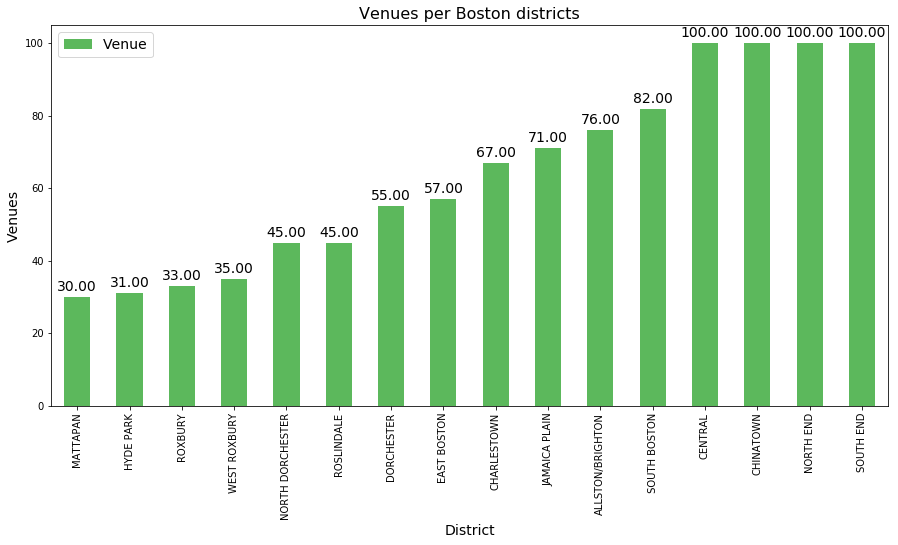

In [136]:
import matplotlib as mpl
import matplotlib.pyplot as plt
bcolors = ['#5cb85c','#5bc0de','#d9534f']
bwidth = 0.5

ax = df_viz.plot(kind='bar', figsize=(15, 7), color = bcolors, width = bwidth, legend=True)

ax.set_title("Venues per Boston districts", fontsize = 16)
ax.set_ylabel('Venues', fontsize = 14)
ax.set_xlabel('District', fontsize = 14)
ax.legend(fontsize = 14)
for p in ax.patches:
    #ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),fontsize=14, ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax

In [137]:
bos_onehot = pd.get_dummies(bos_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bos_onehot['NEIGH'] = bos_venues['NEIGH'] 

# move neighborhood column to the first column
fixed_columns = [bos_onehot.columns[-1]] + list(bos_onehot.columns[:-1])
bos_onehot = bos_onehot[fixed_columns]

bos_onehot.head()

,NEIGH,ATM,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Garden,Belgian Restaurant,Big Box Store,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Café,Cambodian Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Rental Service,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Track,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,HYDE PARK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HYDE PARK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HYDE PARK,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HYDE PARK,0,0,0,0,0,1,0,

In [138]:
bos_grouped = bos_onehot.groupby('NEIGH').mean().reset_index()
bos_grouped.head()

,NEIGH,ATM,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Garden,Belgian Restaurant,Big Box Store,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Café,Cambodian Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Rental Service,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Track,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,SOUTH BOSTON,0.0,0.00,0.0,0.0,0.0,0.024390,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.012195,0.012195,0.060976,0.012195,0.0,0.012195,0.00,0.000000,0.0,0.0,0.012195,0.000000,0.00,0.012195,0.00,0.02439,0.0,0.0,0.00,0.000000,0.0,0.0,0.012195,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.048780,0.00,0.0,0.0,0.036585,0.02439,0.0,0.00,0.00,0.0,0.000000,0.00,0.012195,0.036585,0.0,0.02439,0.012195,0.012195,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.036585,0.0,0.00,0.0,0.012195,0.00,0.0,0.012195,0.000000,0.0,0.012195,0.000000,0.000000,0.012195,0.000000,0.000000,0.0,0.012195,0.000000,0.0,0.00,0.0,0.036585,0.00,0.024390,0.000000,0.0,0.060976,0.012195,0.0,0.00,0.012195,0.00,0.00,0.0,0.00,0.00,0.012195,0.012195,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.012195,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.036585,0.0,0.00,0.00,0.00,0.0,0.0,0.024390,0.0,0.00,0.0,0.000000,0.036585,0.048780,0.0,0.0,0.000000,0.000000,0.024390,0.0,0.000000,0.012195,0.012195,0.00,0.000000,0.012195,0.000000,0.024390,0.012195,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.02439,0.00,0.000000,0.0,0.000000,0.000000,0.012195,0.000000,0.00,0.000000,0.000000,0.00,0.012195,0.00,0.000000,0.012195,0.0,0.00,0.

In [139]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [174]:
num_top_venues = 10


indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NEIGH']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['NEIGH'] = bos_grouped['NEIGH']

for ind in np.arange(bos_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bos_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(2)

,NEIGH,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,SOUTH BOSTON,Bar,Italian Restaurant,Coffee Shop,Pizza Place,Pharmacy,New American Restaurant,Convenience Store,Diner,Hotel,Food Truck
1,ALLSTON/BRIGHTON,Pizza Place,Café,Grocery Store,Bakery,Pub,Donut Shop,Chinese Restaurant,Sushi Restaurant,Deli / Bodega,Coffee Shop


In [175]:
bos_grouped_clustering = bos_grouped.drop('NEIGH', 1).index

In [142]:
#from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist  
#import matplotlib.pyplot as plt

1 : 0.1503927238646307
2 : 0.13286027125699884
3 : 0.11923867328771699
4 : 0.10966849881430354
5 : 0.0959976961759005
6 : 0.0855967175427997
7 : 0.08018462693975939
8 : 0.07115136584946684
9 : 0.05896161756607986
10 : 0.05521582820150208
11 : 0.04707745332692501
12 : 0.03645707452104501
13 : 0.026008140195868314
14 : 0.018707549299732847
15 : 0.00914296177395487
16 : 3.339838900133206e-18


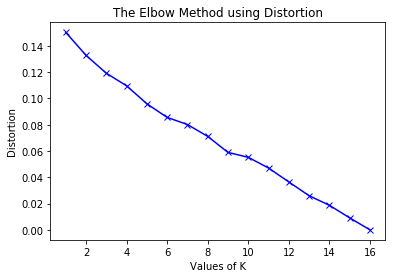

1 : 0.387616457679419
2 : 0.3112783772751382
3 : 0.26544031784171007
4 : 0.2274024094156299
5 : 0.18713014406933864
6 : 0.1601784598658828
7 : 0.1395802019870341
8 : 0.11933100968547619
9 : 0.09958655669554788
10 : 0.0783477812447661
11 : 0.06325544649179846
12 : 0.04881801340630916
13 : 0.0348429441542316
14 : 0.022409610820898263
15 : 0.010700000000000001
16 : 0.0


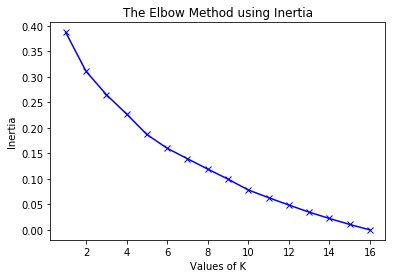

In [143]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,17) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(bos_grouped_clustering) 
    kmeanModel.fit(bos_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(bos_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / bos_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(bos_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / bos_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 


plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

[0.3200446270406649, 0.06991306949476396, 0.07181221802990898, 0.04835948645144758, 0.07107098509209336, 0.051393982543511504, 0.04448448762387411, 0.05315373551908652, 0.040237358022515185, 0.04413989616966687, 0.0360002475570734, 0.03488730554394641, 0.01610636399697929, 0.006518984930617105]


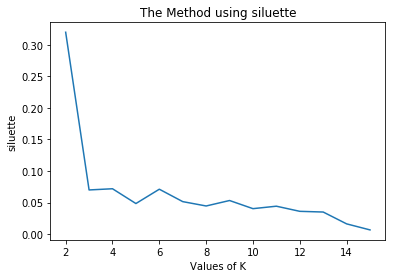

In [144]:
from sklearn.metrics import silhouette_score

silt = []
kmax = 15
K = []
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(bos_grouped_clustering)
  labels = kmeans.labels_
  silt.append(silhouette_score(bos_grouped_clustering, labels, metric = 'euclidean'))
  K.append(k)
print (silt)
plt.plot(K, silt) 
plt.xlabel('Values of K') 
plt.ylabel('siluette') 
plt.title('The Method using siluette') 
plt.show() 

In [176]:
kclusters = 3

bos_grouped_clustering = bos_grouped.drop('NEIGH', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bos_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int32)

In [177]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bos_merged = df_lib

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bos_merged = bos_merged.join(neighborhoods_venues_sorted.set_index('NEIGH'), on='NEIGH')

bos_merged.head(2) # check the last columns!

,index,Longitude,Latitude,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,-71.122136,42.257104,HYDE PARK,1,Grocery Store,American Restaurant,Park,Pharmacy,Donut Shop,Pizza Place,Business Service,Sandwich Place,Plaza,Platform
1,3,-71.111099,42.320646,JAMAICA PLAIN,0,Mexican Restaurant,Coffee Shop,American Restaurant,Pizza Place,Liquor Store,Sandwich Place,Grocery Store,Bakery,Cuban Restaurant,Convenience Store


In [178]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(bos_merged['Latitude'], bos_merged['Longitude'], bos_merged['NEIGH'], bos_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_boston)
       
map_boston

In [161]:
bos_merged.loc[bos_merged['Cluster Labels'] == 0, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,CENTRAL,0,Spa,Seafood Restaurant,Hotel,American Restaurant,Sporting Goods Shop,Ice Cream Shop,Gym,Gym / Fitness Center,Italian Restaurant,Coffee Shop
4,SOUTH END,0,American Restaurant,Italian Restaurant,Coffee Shop,French Restaurant,Bakery,Wine Bar,Mexican Restaurant,Park,Gym,Wine Shop
15,CHINATOWN,0,Asian Restaurant,Coffee Shop,Bakery,Sandwich Place,Chinese Restaurant,Theater,Seafood Restaurant,Italian Restaurant,Sushi Restaurant,Park


In [162]:
bos_merged.loc[bos_merged['Cluster Labels'] == 1, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,ALLSTON/BRIGHTON,1,Pizza Place,Café,Grocery Store,Bakery,Pub,Donut Shop,Chinese Restaurant,Sushi Restaurant,Deli / Bodega,Coffee Shop
9,EAST BOSTON,1,Italian Restaurant,Latin American Restaurant,Mexican Restaurant,Chinese Restaurant,Sandwich Place,Park,Donut Shop,Pizza Place,Pharmacy,Airport Terminal


In [163]:
bos_merged.loc[bos_merged['Cluster Labels'] == 2, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,NORTH END,2,Italian Restaurant,Seafood Restaurant,Bakery,Park,Pizza Place,Historic Site,Coffee Shop,Café,Sandwich Place,Japanese Restaurant


In [164]:
bos_merged.loc[bos_merged['Cluster Labels'] == 3, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,MATTAPAN,3,Caribbean Restaurant,Pizza Place,Liquor Store,Home Service,Pharmacy,Donut Shop,Bakery,Hot Dog Joint,Rental Car Location,Nightclub


In [165]:
bos_merged.loc[bos_merged['Cluster Labels'] == 4, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,JAMAICA PLAIN,4,Mexican Restaurant,Coffee Shop,American Restaurant,Pizza Place,Liquor Store,Sandwich Place,Grocery Store,Bakery,Cuban Restaurant,Convenience Store
6,CHARLESTOWN,4,Donut Shop,Park,Pizza Place,Gastropub,History Museum,National Park,Coffee Shop,Bar,Convenience Store,Boat or Ferry
7,DORCHESTER,4,Pizza Place,Donut Shop,Liquor Store,American Restaurant,Plaza,Metro Station,Pharmacy,Café,Mobile Phone Shop,Park
11,ROSLINDALE,4,Pizza Place,American Restaurant,Grocery Store,Liquor Store,Plaza,Bar,Yoga Studio,Italian Restaurant,Discount Store,Farmers Market
13,WEST ROXBURY,4,American Restaurant,Bank,Pharmacy,Liquor Store,Grocery Store,Pizza Place,Convenience Store,Salon / Barbershop,Spa,Mediterranean Restaurant
14,SOUTH BOSTON,4,Bar,Italian Restaurant,Coffee Shop,Pizza Place,Pharmacy,New American Restaurant,Convenience Store,Diner,Hotel,Food Truck


In [166]:
bos_merged.loc[bos_merged['Cluster Labels'] == 5, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,ROXBURY,5,Gym,Park,Brewery,Coffee Shop,Zoo Exhibit,Fast Food Restaurant,Farmers Market,Mexican Restaurant,Shopping Mall,Museum


In [167]:
bos_merged.loc[bos_merged['Cluster Labels'] == 6, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,HYDE PARK,6,Grocery Store,American Restaurant,Park,Pharmacy,Donut Shop,Pizza Place,Business Service,Sandwich Place,Plaza,Platform


In [168]:
bos_merged.loc[bos_merged['Cluster Labels'] == 7, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]

,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,NORTH DORCHESTER,7,Pizza Place,Caribbean Restaurant,Pharmacy,Food & Drink Shop,Bar,Fried Chicken Joint,Discount Store,Liquor Store,American Restaurant,Vietnamese Restaurant


In [ ]:
bos_merged.loc[bos_merged['Cluster Labels'] == 8, bos_merged.columns[[0] + list(range(4, bos_merged.shape[1]))]]

In [ ]:
bos_merged.loc[bos_merged['Cluster Labels'] == 9, bos_merged.columns[[0] + list(range(4, bos_merged.shape[1]))]]

In [ ]:
bos_merged.loc[bos_merged['Cluster Labels'] == 10, bos_merged.columns[[0] + list(range(4, bos_merged.shape[1]))]]

In [ ]:
bos_merged.loc[bos_merged['Cluster Labels'] == 11, bos_merged.columns[[0] + list(range(4, bos_merged.shape[1]))]]

# Coordinates for clusters

# Wrong coordinates

In [ ]:
!wget --quiet https://opendata.arcgis.com/datasets/acedd06b39854088b0f2fefccffebf84_0.geojson -O boston_commc_geo.json
commc = []
commcg = []
with open ('boston_commc_geo.json') as f:
    data = json.load(f)

for feature in data['features']:
    commc.append(feature['properties'])
    commcg.append(feature['geometry'])
df4 = pd.DataFrame(commc)
df5 = pd.DataFrame(commcg)
df_comm = pd.concat([df4, df5], axis = 1)
df_comm = df_comm[['NEIGH', 'ZIP', 'coordinates']]
df_comm.sort_values(by = ['NEIGH', 'ZIP'], inplace = True)
df_comm.drop_duplicates(subset ="ZIP",inplace = True)
df_comm.drop_duplicates(subset ='NEIGH',inplace = True)
df_comm.reset_index(drop = True)
y_lst = []
x_lst = []
for xc in df_comm['coordinates'].values:
    x_lst.append(xc[0])
    y_lst.append(xc[1])
df_comm['Latitude'] = y_lst
df_comm['Longitude'] = x_lst
df_boston = df_comm[['NEIGH', 'Latitude','Longitude']]
df_boston.reset_index(drop = True)
'''
latit = list(df_boston.Latitude)
longit = list(df_boston.Longitude)
labels = list(df_boston.NEIGH)
#labels1 = list(df_boston.ZIP)

for lt, lg, lbl in zip(latit, longit, labels):
    folium.Marker([lt, lg],popup=lbl).add_to(map_boston)
map_boston
'''

In [ ]:
#Police stations vizualization as markers
'''
latitudes = list(df1.Y)
longitudes = list(df1.X)
labels = list(df1.District)
labels1 = list(df1.NAME)

for lat, lng, label,label1 in zip(latitudes, longitudes, labels, labels1):
    folium.Marker([lat, lng],
                  popup=[label,label1]
                 ).add_to(map_boston)
'''